In [1]:
import torch
from torch.autograd import Variable
from functorch import vmap
import matplotlib.pylab as plt
import numpy as np
import scipy.stats as ss

import random

This code applies variational inference based on time-dependent OU processes to the observations drawn from the double well system SDE, as defined below. Note that we have chosen observational noise, i.e. variance of Gaussian noise and SDE variance to be 0.04 and 0.8 repectively. While the former is equal to the paramterization considered in Archambeau et al 2007, the latter is higher (0.8 vs 0.5)

m(t) = $\alpha$t + $m_{0}$

Noisy Observations from the SDE:

$dX_{t} = rX_{t}dt + X_{t} dW_{t}$

$Y_{t} \sim N(X_{t}, \sigma^{2}_{obs})$

where

$r = 0.0001, \sigma_{obs} = 0.01$

**Generate observations from Gaussian likelihood**

In [246]:
# Time step the SDE: dot X = -mu X + sigma xi, by Euler's method.

# Problem setup. 
# Set model and numerical parameters, and the initial condition.
# These are the lines the user might want to vary.
tf = 1
Nsteps = 10000
Npaths = 1
X0 = 1
obs_sigma = 0.04

# Generate the time grid and solution array
t, dt = np.linspace(0,tf,Nsteps+1,retstep=True)
X = np.zeros((Nsteps+1,Npaths))
root_dt = np.sqrt(dt)
  
# Time step starting from initial condition
X[0,:] = X0;
for n in range(Nsteps):
    F_of_X = 0.0001 * X[n,:]
    X[n+1,:] = X[n,:] + dt * F_of_X + X[n,:] * root_dt * np.random.randn(Npaths)

# Observations with Gaussian noise
obs = np.random.normal(loc = X[::6], scale = obs_sigma)
obs_time = t[::6]

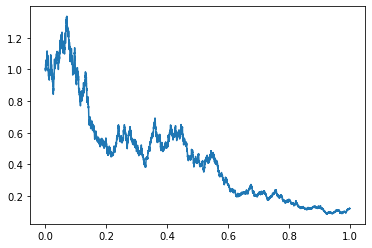

In [247]:
plt.plot(t, X)

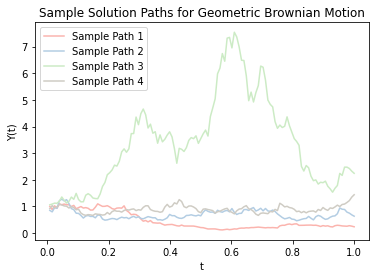

In [243]:
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4"]
# SDE model parameters
mu, sigma, X0 = 0.0001, 1, 1

# Simulation parameters
T, N = 1, 2**7
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Initiate plot object
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.ylabel('Y(t)'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);

Change dtype

In [79]:
true_sde_pts = torch.from_numpy(t)
true_sde_trj = torch.from_numpy(X.flatten())

In [80]:
obs = torch.from_numpy(obs)
obs_time = torch.from_numpy(obs_time)

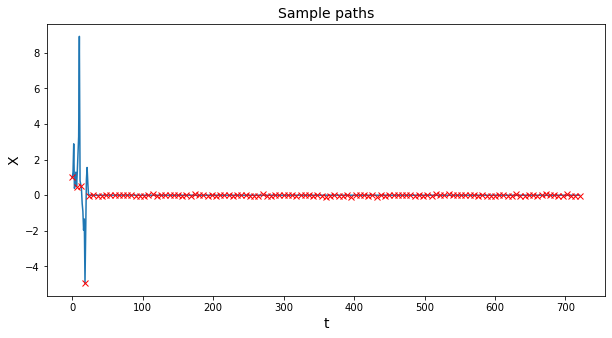

In [81]:
# Plot paths
plt.figure(figsize=(10,5))
plt.plot(t,X)
plt.plot(obs_time, obs, "rx")
plt.xlabel("t", fontsize=14)
plt.ylabel("X", fontsize=14)
plt.title("Sample paths", fontsize=14)
plt.show()


In [ ]:
class OU:
    def __init__(self, t0, t1, z0, alpha, beta, sigma, dN):
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0]
        self.trj, self.dt = self.simulate()
        
    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
        """
        output = np.empty(len(self.pts))
        output[0] = self.z0
        interval = self.pts[1:] - self.pts[:-1]
        for t in range(1, len(self.pts)):
            
            # if the distance is too small, variance becomes 0
            dt = interval[t-1]
            
            mean = self.alpha + (output[t-1] - self.alpha) * np.exp(-1 * self.beta * dt)
            var = np.sqrt((self.sigma ** 2) * (1 - np.exp(-2 * self.beta * dt)) / (2 * self.beta))
            assert var > 0, "variance is negative, var:%.3f interval: %.3f" % (var, dt)
            output[t] = ss.norm.rvs(loc = mean, scale = var)
        return torch.from_numpy(output), interval

**Class: OU processes**

In [ ]:
class tOU_vector:
    """
        simulate multiple trajectories at one-go via vectorisation;
        
    """
    
    def __init__(self, t0, t1, z0, m0, alpha, beta, sigma, r, dN, D, timegrid = 'True'):
        """
        
        """
        self.t0 = t0
        self.t1 = t1
        self.z0 = z0
        self.m0 = m0
        
        self.alpha = alpha
        self.beta = beta
        self.sigma = sigma
        self.r = r
        """
            # of trajectories you wish to sample
        """
        self.D = D
        if timegrid == 'True':
            self.pts = torch.linspace(t0, t1, dN).repeat(D, 1)
        else:
            self.pts = torch.sort(torch.cat([(t1 - t0) * torch.rand(D, dN-2) + t0, torch.tensor([self.t0, self.t1]).repeat(D,1)], axis=1), axis=1)[0]
#             self.pts = torch.sort(torch.cat([torch.DoubleTensor(dN-2).uniform_(t0,t1), torch.tensor([self.t0, self.t1])]))[0].repeat(D,1)
        self.trj, self.dt = self.simulate()

    def simulate(self):
        """
            Simulate an OU process on a set of discrete points
            outcome
                D by N matrices whose row corresponds to one independent time-dependent OU process
        """
        output = torch.empty(self.pts.shape)
        output[:,0] = self.z0.flatten()
        interval = self.pts[:, 1:] - self.pts[:, :-1]
        beta_t = self.alpha * ((( self.pts[:, :-1] + 1) ** self.beta) - 1 ) + self.m0 \
                - np.exp(self.r * interval) * (self.alpha * (((self.pts[:, 1:] + 1)**self.beta) - 1) + self.m0)
        for t in range(1, self.pts.shape[1]):
            # if the distance is too small, variance becomes 0
            mean = (output[:, t-1] - beta_t[:, t-1]) * torch.exp(-1 * self.r.flatten() * interval[:, t-1] )
            var = ((self.sigma ** 2 ) / (2*self.r.flatten())) * (1 - torch.exp(-2 * self.r.flatten() * interval[:, t-1]))
            if self.D > 1:
                output[:, t] = torch.from_numpy(ss.multivariate_normal.rvs(mean = mean, cov = torch.diag(var)))
            else:
                assert var > 0, "variance is negative, sd:%.3f interval: %.3f" % (var, interval[t-1] )
                output[:, t] = ss.norm.rvs(loc = mean, scale = np.sqrt(var))
            
        return [output, interval]

Variational inference: KL

In [ ]:
class ELBO:

    """
        Given a simulated variational process, compute the gradient of the ELBO. 
    """
    def __init__(self, ou):
        self.ou = ou
        self.alpha = ou.alpha
        self.beta = ou.beta
        self.sigma = torch.tensor(ou.sigma)
        self.r = ou.r
        self.m0 = ou.m0
        
    def KL_ito(self):
        """
            1. Compute the Riemann approximation to integral in KL divergence
            
        """
        # Save parameter specification from ou class
        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        
        def B(s, beta):
            return (s+1) ** beta
        
        # Obtain integral term (via Riemann approximation, e.g. trapezoid)
        func = lambda s, z: 16 * (z**6) - 32 * (z**4) + (16-(r**2))*(z**2) \
                - 2*r*alpha*beta*z*(B(s, beta-1) - (beta - 1) * B(s, beta-2)) - 12 * (sigma ** 2) * (z ** 2) \
                + (2*r*z + r*alpha*(B(s, beta) - 1) + r*m0 + alpha*beta*B(s, beta-1)) * (r * alpha * (B(s, beta) - 1) + r*m0 + \
                                                                                alpha * beta * B(s, beta-1))
        
        num = func(self.ou.pts, self.ou.trj)

        return -0.5 * torch.trapezoid(num, x=self.ou.pts).reshape(-1, 1) / (sigma ** 2)
    
    def KL_rest(self):
        """
            2. Compute the rest
        """

        alpha, beta, sigma, r, m0 = self.alpha, self.beta, self.sigma, self.r, self.m0
        D = self.ou.D
        
        z0 = self.ou.z0

        z1 = self.ou.trj[:, -1].reshape(D, 1)
        t0 = self.ou.t0.clone().detach().repeat(D, 1)
        t1 = self.ou.t1.clone().detach().repeat(D, 1)
        
        # Obtain the rest 
        def A(s, u):
            return (-1 * (u ** 4) + (4+r)*(u ** 2)/2 - u*r*(alpha*((s+1) ** beta - 1) + m0 - alpha*beta*((s+1) ** (beta-1))))
            
        
        return (A(t1, z1) - A(t0, z0)) / (sigma ** 2) - 0.5 * (t1 - t0) * (r+4)
    
    def log_prob(self, obs, obs_sigma):
        """
            Compute the log-likelihood
            likelihood function is normal density N(obs, var)
            obs.shape = D * 1 (D: # of sample)
        """
        def log_pdf(obs, z, obs_sigma):
            return ss.norm.logpdf(obs, loc=z, scale=obs_sigma)
            
        return torch.from_numpy(log_pdf(obs, self.ou.trj[:, -1].reshape(-1, 1), obs_sigma))


In [ ]:
class Score:
    def __init__(self, ou):
        self.ou = ou
        
    def compute_score(self, alpha, beta, m0, r):
        """
            Compute the value of the score function at given parameters
            return a dictionary matching each parameter to its gradient
        """
        D = self.ou.D
        
        sigma = torch.tensor(self.ou.sigma).repeat(D, 1)
        alpha = Variable(alpha, requires_grad = True)
        beta = Variable(beta, requires_grad = False)
        m0 = Variable(m0, requires_grad = True)
        r = Variable(r, requires_grad = True)
        
        pts = self.ou.pts
        dt = self.ou.dt
        X = self.ou.trj
         
        def compute_transition(X, dt, alpha, beta, sigma, m0, pts):
            """
            Compute the transition density of the (simulated) path
            Note that if r < 0, term1 becomes nan ( there is a constraint that r > 0)
            """
            beta_t = alpha * (((pts[:, :-1] + 1) ** beta) - 1) + m0 - torch.exp(r * dt) * (alpha * (((pts[:, 1:] + 1) ** beta) - 1) + m0) 
            term1 = -0.5 * (2 * torch.log(sigma) + torch.log( 1 - torch.exp(-2 * r * dt)) - torch.log( r ))
            term2 = X[:,1:] - (X[:,:-1] - beta_t) * torch.exp( -1 * r * dt)
            term3 = (sigma ** 2) * (1 - torch.exp(-2 * r * dt)) / r
#             print("beta_t = ", beta_t, "term1 = ", term1)
            return torch.sum( term1 - ((term2 ** 2) / term3), axis=1)
        
        NLL = compute_transition(X, dt, alpha, beta, sigma, m0, pts)
#         NLL.backward()
        NLL.backward(torch.tensor([1.]).repeat(D))
        
        return {'m0':m0.grad.detach().clone(), 'alpha':alpha.grad.detach().clone(), "r":r.grad.detach().clone(), 'LNN':NLL.data.numpy()}

**Variational inference: a piece-wise approximation**

1. one-time variational inference from t=0 to t=1

In [ ]:
import tqdm as tq

In [ ]:
D = 30

alpha_ = torch.tensor([0.])
r_ = torch.tensor([0.5])
m0_ = torch.tensor([0.])
beta_D = torch.tensor([1.]).repeat(D,1)
z0 = obs[0].repeat(D,1)

learning_rate = 0.001
lr = learning_rate

trace_pars = []
trace_elbo = []
for k in tq.tqdm(range(150)):
    alpha_D = alpha_.repeat(D, 1)
    r_D = r_.repeat(D, 1)
    m0_D = m0_.repeat(D, 1)
    # Compute (negative) ELBO
    vi_ = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=z0, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo_ = ELBO(vi_)
    elbo_estimate = -1 * (elbo_.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo_.KL_ito() + elbo_.KL_rest())
    

    trace_pars.append((m0_.clone(), alpha_.clone(), r_.clone()))
    trace_elbo.append(torch.mean(elbo_estimate))
    
    # Obtain score function estimator of the gradient
    vi = tOU_vector(t0=obs_time[0], t1=obs_time[1], z0=z0, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=40, D=D, timegrid = 'False')
    elbo = ELBO(vi)
    score = Score(vi)

    scores = score.compute_score(alpha_D, beta_D, m0_D, r_D)
    f_of_X = -1 * (elbo.log_prob(obs[1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
    m0_grad = torch.mean(f_of_X * scores['m0'])
    alpha_grad = torch.mean(f_of_X * scores['alpha'])
    r_grad = torch.mean(f_of_X * scores['r'])

    # Update the parameter
    m0_ -= learning_rate * m0_grad
    alpha_ -= learning_rate * alpha_grad
    r__ = r_ - learning_rate * r_grad
    
    # It is to ensure r should be strictly positive (i.e. projected gradient method)
    while r__ < 0:
        r__ = r_ - lr * r_grad
        lr *= 0.5
    r_ = r__
    
    print("m0 = ", m0_, "alpha = ", alpha_, "r = ", r_, '(Negative) ELBO = ', torch.mean(elbo_estimate))
    
    
# score.compute_score()

**Posterior mean**

In [ ]:
compute_mean = lambda x: alpha_ * (((x + 1) ** beta_D[0]) - 1) + m0_D[0]

In [ ]:
plt.plot(true_sde_pts[:100], compute_mean(true_sde_pts)[:100], color='black', label="(theoretical) posterior mean")
plt.plot(true_sde_pts[::100][:2], obs[:2], 'rx', label='observations')
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
S = 30
posterior = tOU_vector(t0 = obs_time[0], t1 = obs_time[1], z0 = z0, m0 = m0_D, alpha = alpha_, beta = beta_D, sigma = 1, r = r_, D = S, dN = 30, timegrid='True')
plt.plot(posterior.pts.T, posterior.trj.T, 'b')
plt.plot(posterior.pts.T[0], posterior.trj.T[0], 'b', label="posterior sample")
plt.plot(obs_time, obs, 'rx', label='Observations')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed', label="underlying SDE")
plt.legend()
plt.show()

In [ ]:
post_mean = torch.mean(posterior.trj, axis=0)
post_std = torch.std(posterior.trj, axis=0)

plt.plot(posterior.pts[0], post_mean, color='black')
plt.fill_between(posterior.pts[0], post_mean + post_std, post_mean - post_std, color='grey', alpha=0.3)
plt.plot(obs_time, obs, 'rx')
plt.plot(true_sde_pts,true_sde_trj, 'grey', linestyle='dashed')

**Trace plot: parameters**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
names = [r'$m0$', r'$\alpha$', 'r']
for i, ax in enumerate(ax.ravel()):
    par = [item[i].data.numpy() for item in trace_pars]
    ax.plot(np.arange(len(par)), par)
    ax.set_title(names[i])
    ax.set_xlabel('iterations')
    ax.set_ylabel(names[i])
# plt.title("Trace plot: beta")
# plt.plot(np.arange(len(betas)), betas)
# plt.xlabel("iteration")
# plt.ylabel(r"$\beta$")
# plt.show()

**Trace plot: ELBO**

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for i, ax in enumerate(ax.ravel()):
    ax.set_title("Trace plot: (Negative) ELBO")
    if i == 0:
        ax.plot(np.arange(len(trace_elbo[1:])), trace_elbo[1:])
    else:
        ax.plot(np.arange(len(trace_elbo[50:])), trace_elbo[50:])
        ax.set_title("(After 100 iterations) Trace plot: (Negative) ELBO")
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO")
plt.show()

**Posterior credible interval (constructed by monte carlo estimator based on sample from time-depenent OU with fitted variational parameters**

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(obs_time, obs, 'rx', label="observations")
plt.plot(true_sde_pts,true_sde_trj, 'red', linestyle='dashed', alpha= 0.3, label='underlying SDE')
plt.plot(posterior.pts[0], post_mean, color='black', label="posterior mean")
plt.fill_between(posterior.pts[0], post_mean - post_std, post_mean + post_std, color='grey', alpha=0.3)
plt.legend()
plt.xlabel("time")
plt.ylabel("x")
plt.show()

In [ ]:
D = 100
S = 50
learning_rate = 0.00005
lr = learning_rate
IT = 250
dN = 30
z0 = obs[0]

beta_D = torch.tensor([1.]).repeat(D, 1)

vp_mean = []
vp_std = []
vp_pts = []

elbo_traces = np.empty((len(obs_time) - 1, IT-1))
KL_traces = np.empty((len(obs_time) -1 , IT-1))
NLL_traces = np.empty((len(obs_time) -1 , IT-1))
pars_traces = np.empty((3, len(obs_time) - 1, IT))

for t in tq.tqdm(range(obs.shape[0]-1)):
    # initilize a set of parameters
    alpha_ = torch.tensor([0.])
    r_ = torch.rand(1)
    m0_ = torch.rand(1)
    
    i = 0
    conv = 1
    while (conv > 0.00005) and (i < IT): 
        alpha_D = alpha_.repeat(D, 1)
        r_D = r_.repeat(D, 1)
        z0_D = z0.repeat(D, 1)
        m0_D = m0_.repeat(D, 1)
        # Compute (negative) ELBO
        if i > 0:
            vi_ = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
            elbo_ = ELBO(vi_)
            kl_ = elbo_.KL_ito() + elbo_.KL_rest()
            NLL_ = elbo_.log_prob(obs[t+1].repeat(D, 1), obs_sigma)
            elbo_estimate = -1 * (kl_ + NLL_)
            elbo_traces[t, i-1] = torch.mean(elbo_estimate).clone()
            KL_traces[t, i-1] = torch.mean(kl_).clone()
            NLL_traces[t, i-1] = torch.mean(NLL_).clone()
            if i % 50 == 1:
                print("(Neg) elbo = ", torch.nanmean(elbo_estimate).data.numpy())
        # Obtain score function estimator of the gradient
        vi = tOU_vector(t0=obs_time[t], t1=obs_time[t+1], z0=z0_D, m0=m0_D, alpha=alpha_D, beta=beta_D, sigma=sde_sigma, r=r_D, dN=dN, D=D, timegrid = 'False')
        elbo = ELBO(vi)
        score = Score(vi)

        scores = score.compute_score(alpha_D, beta_D, m0_D, r_D)
#         print("scores = ", scores)
        f_of_X = -1 * (elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma) + elbo.KL_ito() + elbo.KL_rest())
#         print("Ito = ", elbo.KL_ito(), "Rest = ", elbo.KL_rest(), "LL = ", elbo.log_prob(obs[t+1].repeat(D, 1), obs_sigma))
#         print("f_of_X = ", torch.nanmean(f_of_X))
#         print("NLL = ", "KL_Ito = ", "KL_rest = ")
        
#         print("scores_beta = ", torch.nanmean(scores['beta']), "scores_alpha = ", torch.nanmean(scores['alpha']))
        m0_grad = torch.nanmean(f_of_X * scores['m0'])
        alpha_grad = torch.nanmean(f_of_X * scores['alpha'])
        r_grad = torch.nanmean(f_of_X * scores['r'])
#         print("beta_grad = ", beta_grad, "alpha_grad = ", alpha_grad, "r_grad = ", r_grad)

        # Update the parameter

        m0_ -= learning_rate * m0_grad
        alpha_ -= learning_rate * alpha_grad
        r__ = r_ - learning_rate * r_grad

#             It is to ensure r should be strictly positive (i.e. projected gradient method)
        while r__ < 0:
            r__ = r_ - lr * r_grad
            lr *= 0.5
        r_ = r__

        pars_traces[0, t, i] = alpha_.clone()
        pars_traces[1, t, i] = m0_.clone()
        pars_traces[2, t, i] = r_.clone()

        if i % 50 == 0:
            print("alpha = ", alpha_.data.numpy(), "m0 = ", m0_.data.numpy(), "r = ", r_.data.numpy())
        i += 1
#     Compute posteiror mean (based on posterior sample)
    posterior = tOU_vector(t0 = obs_time[t], t1 = obs_time[t+1], z0 = z0.repeat(S, 1), m0 = m0_[0].repeat(S, 1), alpha = alpha_, beta = beta_D[0], sigma = sde_sigma, r = r_, D = S, dN = dN, timegrid='True')
    
    
    if t > 0:
        post_mean_ = posterior.trj.mean(axis=0)[1:]
        post_std_ = posterior.trj.std(axis=0)[1:]
        post_pts_ = posterior.pts.mean(axis=0)[1:]
    else:
        post_mean_ = posterior.trj.mean(axis=0)
        post_std_ = posterior.trj.std(axis=0)
        post_pts_ = posterior.pts.mean(axis=0)
    
    vp_mean.append(post_mean_.clone().data.numpy())
    vp_std.append(post_std_.clone().data.numpy())
    vp_pts.append(post_pts_.clone().data.numpy())
#     z0 = torch.tensor(obs[t+1])
    z0 = post_mean_.clone()[-1]
#     print("posterior_mean = ", z0)
# score.compute_score()

Trace plot: ELBO

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(elbo_traces[t, :])), elbo_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("Negative ELBO, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) ELBO", size=15, y=0.95)
plt.show()

Trace plot: KL divergence

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(KL_traces[t, :])), -1 * KL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("KL, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: KL divergence", size=15, y=0.95)
plt.show()

Trace plot: NLL

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 13))
t = 0
for ax in ax.ravel()[:-1]:
    ax.plot(np.arange(len(NLL_traces[t, :])), -1 * NLL_traces[t, :])
    ax.set_xlabel("iteration")
    ax.set_ylabel("(Negative) Log Likelihood, dt = %d" % t)
    t += 1
    
plt.suptitle("Trace plot: (Negative) Log Likeilhood", size=15, y=0.95)
plt.show()

Trace plot: parameters

In [ ]:
fig, ax = plt.subplots(nrows=pars_traces.shape[1], ncols=3, figsize=(20, 30), sharex='all')
names = [r'$\alpha$', r'$m0$', r'$r$']
for j, ax in enumerate(ax.ravel()):
    i = j % 3
    t = j // 3
    ax.plot(np.arange(pars_traces[i, t, :].shape[0]), pars_traces[i, t, :])
    ax.set_title(names[i] + " at time interval: %d" % t)
    ax.set_yticks(np.linspace(0,2,10))
    if t == 5:
        ax.set_xlabel("Iterations")
plt.show()

**Posterior approximation**

In [ ]:
vi_mean = np.concatenate(vp_mean)
vi_var = np.concatenate(vp_std)
vi_pts = np.concatenate(vp_pts)

plt.figure(figsize=(10, 7))
plt.plot(true_sde_pts, true_sde_trj, label="underlying SDE", alpha=0.4)
plt.plot(obs_time, obs, 'rx', label='observations')
plt.plot(np.linspace(0, 8, vi_mean.shape[0]), vi_mean, color='black', label='variational mean')
plt.fill_between(vi_pts, vi_mean + vi_var, vi_mean - vi_var, alpha=0.3, color='grey', label='variational std')
plt.legend()
plt.xlabel("Time")
plt.ylabel("x")
plt.title("Variational Approximation")
plt.show()